In [79]:
# Libraries
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split
import pprint
from patsy import dmatrices
from yellowbrick.regressor import ResidualsPlot


sns.set()

In [2]:
# Train data
train = pd.read_csv("data_files/train.csv", header = 0)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
building_id      int64
meter            int64
timestamp        object
meter_reading    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 616.9+ MB


In [3]:
# Building meta data
building = pd.read_csv("data_files/building_metadata.csv")
building.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
site_id        1449 non-null int64
building_id    1449 non-null int64
primary_use    1449 non-null object
square_feet    1449 non-null int64
year_built     675 non-null float64
floor_count    355 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.0+ KB


In [4]:
# Weather train data
weather_train = pd.read_csv("data_files/weather_train.csv")
weather_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
site_id               139773 non-null int64
timestamp             139773 non-null object
air_temperature       139718 non-null float64
cloud_coverage        70600 non-null float64
dew_temperature       139660 non-null float64
precip_depth_1_hr     89484 non-null float64
sea_level_pressure    129155 non-null float64
wind_direction        133505 non-null float64
wind_speed            139469 non-null float64
dtypes: float64(7), int64(1), object(1)
memory usage: 9.6+ MB


In [5]:
del train, building, weather_train
_ = gc.collect()

In [6]:
def memory_reduction(df):
    itypes = [np.int8, np. int16, np.int32, np.int64] 
    ftypes = [np.float16, np.float32, np.float64]
    iinfo = [np.iinfo(t) for t in itypes]
    finfo = [np.finfo(t) for t in ftypes]
    for col in df:
        if is_numeric_dtype(df[col]):
            col_max = df[col].max()
            col_min = df[col].min()
            if np.issubdtype(df[col].dtype, np.integer):
                for ii in iinfo:
                    if col_min >= ii.min and col_max <= ii.max:
                        df[col] = df[col].astype(ii.dtype)
                        break
            else:
                for fi in finfo:
                    if col_min >= fi.min and col_max <= fi.max:
                        df[col] = df[col].astype(fi.dtype)
                        break
    return df

In [7]:
def load_data(base, task):
    data = memory_reduction(pd.read_csv(f"{base}/{task}.csv", parse_dates = ['timestamp']))
    building = memory_reduction(pd.read_csv(f"{base}/building_metadata.csv"))
    weather = memory_reduction(pd.read_csv(f"{base}/weather_{task}.csv", parse_dates = ['timestamp']))
    return data.merge(building.merge(weather, on = "site_id", how = "left"), how = "left", on = ["building_id", "timestamp"])

In [8]:
train = load_data("data_files", "train")
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 16 columns):
building_id           int16
meter                 int8
timestamp             datetime64[ns]
meter_reading         float32
site_id               float64
primary_use           object
square_feet           float64
year_built            float16
floor_count           float16
air_temperature       float16
cloud_coverage        float16
dew_temperature       float16
precip_depth_1_hr     float16
sea_level_pressure    float16
wind_direction        float16
wind_speed            float16
dtypes: datetime64[ns](1), float16(9), float32(1), float64(2), int16(1), int8(1), object(1)
memory usage: 1.2+ GB


In [9]:
test = load_data("data_files", "test")
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41697600 entries, 0 to 41697599
Data columns (total 16 columns):
row_id                int32
building_id           int16
meter                 int8
timestamp             datetime64[ns]
site_id               float64
primary_use           object
square_feet           float64
year_built            float16
floor_count           float16
air_temperature       float16
cloud_coverage        float16
dew_temperature       float16
precip_depth_1_hr     float16
sea_level_pressure    float16
wind_direction        float16
wind_speed            float16
dtypes: datetime64[ns](1), float16(9), float64(2), int16(1), int32(1), int8(1), object(1)
memory usage: 2.5+ GB


In [10]:
# Meter types as on the competition page
meter_type = {0: "electricity", 1: "chilledwater", 2: "steam", 3: "hotwater"}

## EDA

### Null Values

<Figure size 432x288 with 0 Axes>

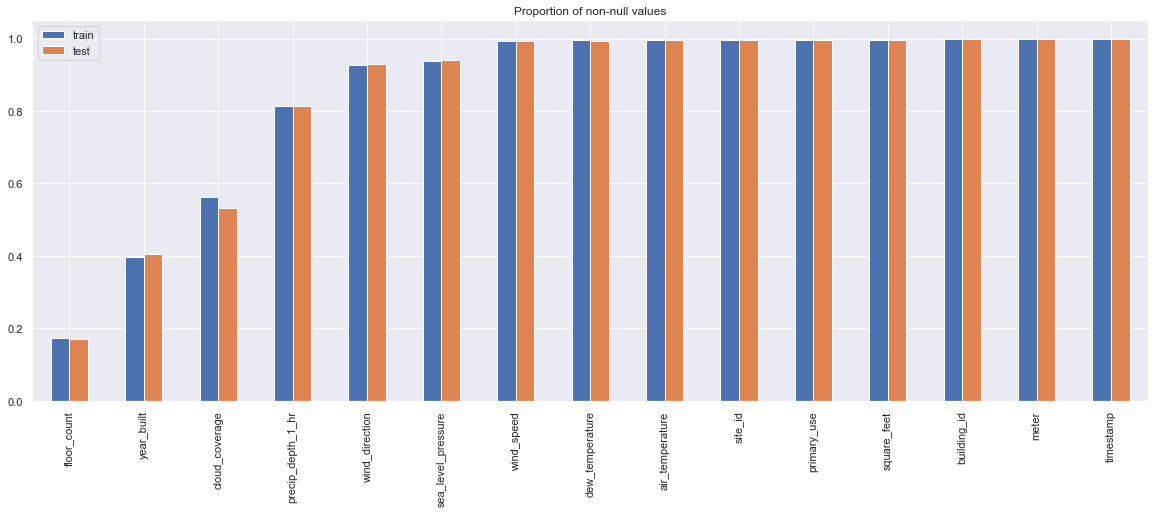

In [11]:
plt.clf()
(train.count()/len(train)).sort_values().to_frame("train").merge((test.count()/len(test)).to_frame("test"), left_index = True, right_index = True).plot.bar(title = "Proportion of non-null values", figsize = (20, 7))

### Target Variable - Meter Reading

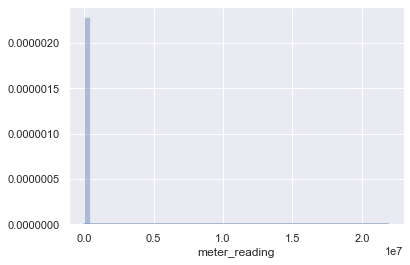

In [12]:
plt.clf()
sns.distplot(train["meter_reading"])

We can't properly visualize "meter_reading" due to some very large values which could be outliers. Let's take a log transformation and visualize the meter reading grouped by meter type.

<Figure size 432x288 with 0 Axes>

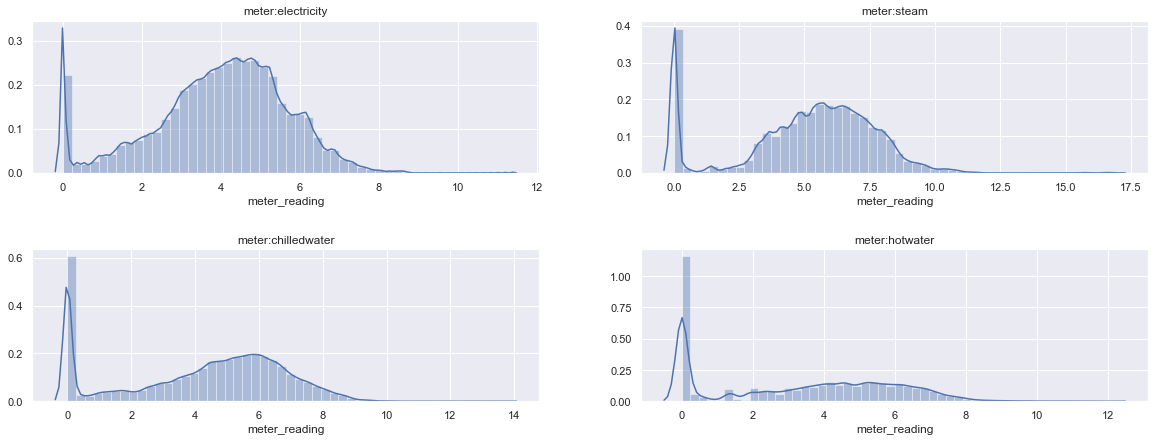

In [13]:
plt.clf()
grouped = train[["meter", "meter_reading"]].groupby("meter")
fig, ax = plt.subplots(2, 2, figsize = (20, 7))
plt.subplots_adjust(hspace = 0.5)
i = 0
for name, group in grouped:
    _ = sns.distplot(np.log1p(group['meter_reading']), ax = ax[i%2, i//2], label = name)
    ax[i%2, i//2].set_title("meter:" + str(meter_type[name])) 
    i+=1

In [14]:
# Summary of meter readings
train['meter_reading'].describe()

count    2.021610e+07
mean     1.988706e+03
std      1.532159e+05
min      0.000000e+00
25%      1.830000e+01
50%      7.877500e+01
75%      2.679840e+02
max      2.190470e+07
Name: meter_reading, dtype: float64

There seems to be a lot of rows with 0 meter readings. Let's see the proportion of data with 0 meter reading..

In [15]:
# Percentage of traininig data with 0 meter_reading
round(train.loc[train.meter_reading == 0, 'meter_reading'].count()*100/len(train), 2)

9.27

Checking the distribution of mean meter reading over time..
Inspired By [EDA for ASHRAE](https://www.kaggle.com/nroman/eda-for-ashrae)

In [ ]:
# Mean meter reading over time
plt.clf()
fig, ax = plt.subplots(figsize = (17, 7))
train[["timestamp", "meter_reading"]].set_index("timestamp").resample("H").mean()["meter_reading"].plot(ax = ax, label = "Hourly", color = "blue", alpha = 0.5)
train[["timestamp", "meter_reading"]].set_index("timestamp").resample("D").mean()["meter_reading"].plot(ax = ax, label = "Daily", color = "orange", alpha = 0.7)
train[["timestamp", "meter_reading"]].set_index("timestamp").resample("W").mean()["meter_reading"].plot(ax = ax, label = "Weekly", color = "yellow", alpha = 0.85)
train[["timestamp", "meter_reading"]].set_index("timestamp").resample("M").mean()["meter_reading"].plot(ax = ax, label = "Monthly", color = "green", alpha = 1)
ax.set_title("Mean meter reading over time")
ax.set_ylabel("meter reading")
ax.legend(loc = "best")

The graph has weird surges from the months of May to June and then again around Novemeber. Let's facet the graph using site_id to see if a particular region is responsible for this anomaly.

In [ ]:
plt.clf()
grouped = train[["site_id", "timestamp", "meter_reading"]].groupby("site_id")
i = 0
fig, ax = plt.subplots(8, 2, figsize = (20, 50), dpi = 400)
for name, group in grouped:
    group.set_index("timestamp").resample("H").mean()["meter_reading"].plot(ax = ax[i%8,i//8], label = "Hourly", color = "blue", alpha = 0.5)
    group.set_index("timestamp").resample("D").mean()["meter_reading"].plot(ax = ax[i%8,i//8], label = "Daily", color = "orange", alpha = 0.7)
    group.set_index("timestamp").resample("W").mean()["meter_reading"].plot(ax = ax[i%8,i//8], label = "Weekly", color = "yellow", alpha = 0.85)
    group.set_index("timestamp").resample("M").mean()["meter_reading"].plot(ax = ax[i%8,i//8], label = "Monthly", color = "green", alpha = 1)
    ax[i%8,i//8].set_title("site_id: " + str(name))
    ax[i%8,i//8].set_ylabel("meter reading")
    ax[i%8,i//8].legend()
    i+=1

Of the above graphs, site_id = 13.0 is exactly similar to the graph we got for overall data implying it's heavily skewing the mean meter reading. Let's dig deeper and study the average meter reading of buildings in site 13.0 grouped by their primary_usage key..

In [ ]:
plt.clf()
grouped = train.loc[train["site_id"] == 13.0, ["primary_use", "timestamp", "meter_reading"]].groupby("primary_use")
i = 0
fig, ax = plt.subplots(7, 2, figsize = (20, 50), dpi = 400)
for name, group in grouped:
    group.set_index("timestamp").resample("H").mean()["meter_reading"].plot(ax = ax[i%7,i//7], label = "Hourly", color = "blue", alpha = 0.5)
    group.set_index("timestamp").resample("D").mean()["meter_reading"].plot(ax = ax[i%7,i//7], label = "Daily", color = "orange", alpha = 0.7)
    group.set_index("timestamp").resample("W").mean()["meter_reading"].plot(ax = ax[i%7,i//7], label = "Weekly", color = "yellow", alpha = 0.85)
    group.set_index("timestamp").resample("M").mean()["meter_reading"].plot(ax = ax[i%7,i//7], label = "Monthly", color = "green", alpha = 1)
    ax[i%7,i//7].set_title("primary_use: " + str(name))
    ax[i%7,i//7].set_ylabel("meter reading")
    ax[i%7,i//7].legend()
    i+=1

The average meter reading for educational buildings seems to be the culprit here. Let's dig deeper and find out if it's just one building that's causing these anomalies..

In [ ]:
plt.clf()
grouped = train.loc[(train["site_id"] == 13.0) & (train["primary_use"] == "Education"), ["building_id", "timestamp", "meter_reading"]].groupby("building_id")
i = 0
fig, ax = plt.subplots(13, 2, figsize = (20, 50), dpi = 400)
for name, group in grouped:
    group.set_index("timestamp").resample("H").mean()["meter_reading"].plot(ax = ax[i%13,i//13], label = "Hourly", color = "blue", alpha = 0.5)
    group.set_index("timestamp").resample("D").mean()["meter_reading"].plot(ax = ax[i%13,i//13], label = "Daily", color = "orange", alpha = 0.7)
    group.set_index("timestamp").resample("W").mean()["meter_reading"].plot(ax = ax[i%13,i//13], label = "Weekly", color = "yellow", alpha = 0.85)
    group.set_index("timestamp").resample("M").mean()["meter_reading"].plot(ax = ax[i%13,i//13], label = "Monthly", color = "green", alpha = 1)
    ax[i%13,i//13].set_title("building_id" + str(name))
    ax[i%13,i//13].set_ylabel("meter reading")
    ax[i%13,i//13].legend()
    i+=1

The building building_id = "1099", site_id = "13.0" and primary_use = "Education" has very average meter reading which is not seen for other buildings. Let's look at 

In [ ]:
train[(train["site_id"] == 13.0) & (train["primary_use"] == "Education") & (train["building_id"] == 1099)].describe()

In [ ]:
plt.clf()
grouped = train.loc[(train["site_id"] == 13.0) & (train["primary_use"] == "Education") & (train["building_id"] == 1099), ["timestamp", "meter", "meter_reading"]].groupby("meter")
fig, ax = plt.subplots(2,2, figsize = (20, 7))
plt.subplots_adjust(hspace = 0.5)
i = 0
for name, group in grouped:
    group.set_index("timestamp").resample("H").mean()["meter_reading"].plot(ax = ax[i%2,i//2], label = "Hourly", color = "blue", alpha = 0.5)
    group.set_index("timestamp").resample("D").mean()["meter_reading"].plot(ax = ax[i%2,i//2], label = "Daily", color = "orange", alpha = 0.7)
    group.set_index("timestamp").resample("W").mean()["meter_reading"].plot(ax = ax[i%2,i//2], label = "Weekly", color = "yellow", alpha = 0.85)
    group.set_index("timestamp").resample("M").mean()["meter_reading"].plot(ax = ax[i%2,i//2], label = "Monthly", color = "green", alpha = 1)
    ax[i%2,i//2].set_title("meter: " + str(meter_type[name]))
    ax[i%2,i//2].set_ylabel("meter reading")
    ax[i%2,i//2].legend()
    i+=1

The steam meter reading for building 1099 is off the charts and skewing the target variable.

For site_id = "13.0" and primary_use = "Services", the meter readings were high too. Looking at meter readings in these categories to see if there's an anomaly..

In [ ]:
plt.clf()
grouped = train.loc[(train["site_id"] == 13.0) & (train["primary_use"] == "Services"), ["building_id", "timestamp", "meter_reading"]].groupby("building_id")
i = 0
fig, ax = plt.subplots(3, 2, figsize = (20, 20), dpi = 400)
for name, group in grouped:
    group.set_index("timestamp").resample("H").mean()["meter_reading"].plot(ax = ax[i%3,i//3], label = "Hourly", color = "blue", alpha = 0.5)
    group.set_index("timestamp").resample("D").mean()["meter_reading"].plot(ax = ax[i%3,i//3], label = "Daily", color = "orange", alpha = 0.7)
    group.set_index("timestamp").resample("W").mean()["meter_reading"].plot(ax = ax[i%3,i//3], label = "Weekly", color = "yellow", alpha = 0.85)
    group.set_index("timestamp").resample("M").mean()["meter_reading"].plot(ax = ax[i%3,i//3], label = "Monthly", color = "green", alpha = 1)
    ax[i%3,i//3].set_title("building_id: " + str(name))
    ax[i%3,i//3].set_ylabel("meter reading")
    ax[i%3,i//3].legend()
    i+=1

The meter_readings are high for building_id = "1197" but it's not too abnormal. We will do further analysis and see if anything comes about it but for now it doesn't seem like an outlier.

### Explanatory Variables

#### Meter

In [ ]:
## Checking the distribution of meter types
plt.clf()
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
trm = train["meter"].map(meter_type).value_counts()
tem = test["meter"].map(meter_type).value_counts()
ind = np.arange(4)
ax.bar(ind, trm.values, color = "yellow", width = 0.3, label = "train")
ax.bar(ind + 0.3, tem.values, color = "green", width = 0.3, label = "test")
ax.set_xticks(ind + 0.3 / 2)
ax.set_xticklabels(trm.index)
ax.legend()
plt.show()

#### site_id

In [ ]:
## Checking the distribution of meter types
plt.clf()
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
trm = train["site_id"].value_counts().sort_index()
tem = test["site_id"].value_counts().sort_index()
# len(trm.index) == len(tem.index)
ind = np.arange(16)
ax.bar(ind, trm.values, color = "yellow", width = 0.3, label = "train")
ax.bar(ind + 0.3, tem.values, color = "green", width = 0.3, label = "test")
ax.set_xticks(ind + 0.3 / 2)
ax.set_xticklabels(trm.index)
ax.legend()
plt.show()

# Analysis

For this project, we are just considering the meter reading of electricity meter due to high volume of data. We are going to do a three step analysis:
1. We will try to see the affect of building configuration/metadata on meter reading.
2. We will incorporate weather and time information and see how these variables, along with the building metadata, affect meter reading
3. We will try some complicated model, LightGBM, and see how it fares with the previous simple linear models

## Preparing Data for Analysis

Since this dataset was taken from a kaggle competition, we don't have meter_readings available for the test dataset. Hence, we will split the train dataset into training set and validation set; the former will be used for training whereas the latter will be used to check the performance of models.

In [ ]:
# Deleting the test dataset
del test

# Garbage collection
gc.collect()

### Subsetting dataset to get rows for meter == "electricity"(0)

In [9]:
# Electricity meter readings
train = train[train["meter"] == 0]

### Missing Data

#### Building Metadata

##### Square Feat

In [10]:
print("Percentage of data with NA in square feet: %d", train["square_feet"].isna().sum()*100/len(train))

Percentage of data with NA in square feet: %d 0.36068588522756573


We know that the square feet value for a building will be same for the entire dataset, unless the building was renovated sometime during the time period for which the data is available, hence we can impute missing values with either the unique square feet value of the building or mean of square feat value. 

In [11]:
na_count = train.groupby("building_id")[["square_feet"]].apply(lambda x: x.isna().sum()/len(x)).squeeze()
print("Buildings with no data for square feet: %d", len(na_count[na_count == 1]))

Buildings with no data for square feet: %d 0


As we can see, that for every building there's atleast one record that contains the square feet value of the building. We will check now if the square feet value is unique for a particular building.

In [12]:
unique_count = train.groupby("building_id")[["square_feet"]].apply(lambda x: x.nunique()).squeeze()
print("Buildings with more than 1 value for square feet", len(unique_count[unique_count != 1]))

Buildings with more than 1 value for square feet 0


Since each building has only one square feet value, we can easily impute the missing values.

In [13]:
sf_na_mapping = train.groupby("building_id")[["square_feet"]].apply(lambda x: x.max()).squeeze()
for bid in sf_na_mapping.index:
    train.loc[train["building_id"] == bid, "square_feet"] = sf_na_mapping[bid]

##### Primary Use

In [14]:
print("Percentage of data with NA in primary use: %d", train["primary_use"].isna().sum()*100/len(train))

Percentage of data with NA in primary use: %d 0.36068588522756573


We know that the primary value for a building will be same for the entire dataset hence we can impute missing values with the unique primary use value of the building.

In [15]:
na_count = train.groupby("building_id")[["primary_use"]].apply(lambda x: x.isna().sum()/len(x)).squeeze()
print("Buildings with no data for primary_use: %d", len(na_count[na_count == 1]))

Buildings with no data for primary_use: %d 0


As we can see, that for every building there's atleast one record that contains the primary use value of the building. We will check now if the primary use value is unique for a particular building.

In [16]:
unique_count = train.groupby("building_id")[["primary_use"]].apply(lambda x: x.nunique()).squeeze()
print("Buildings with more than 1 value for primary use", len(unique_count[unique_count != 1]))

Buildings with more than 1 value for primary use 0


Since each building has only one primary use value, we can easily impute the missing values.

In [17]:
# pp.pprint(train["building_id"].unique().tolist())
train["building_id"].map(type).value_counts()

<class 'int'>    12060910
Name: building_id, dtype: int64

In [18]:
pu_na_mapping = train.groupby("building_id")[["primary_use"]].apply(lambda x: pd.DataFrame(x.max())).reset_index(level = 1, drop = True).squeeze()
for bid in pu_na_mapping.index:
    train.loc[train["building_id"] == bid, "primary_use"] = pu_na_mapping[bid]

##### Floor Count

In [19]:
print("Percentage of data with NA in floor count: %d", train["floor_count"].isna().sum()*100/len(train))

Percentage of data with NA in floor count: %d 75.46836018177733


Since about $\frac{3}{4}$ of the records have missing data for floor count, we might have to drop this column.

In [20]:
na_count = train.groupby("building_id")[["floor_count"]].apply(lambda x: x.isna().sum()/len(x)).squeeze()
print("Buildings with no data for floor count: %d", len(na_count[na_count == 1]))

Buildings with no data for floor count: %d 1061


As we can see more than a thousand buildings, out of a total of about 1500 buildings for which the dataset has meter_reading records, don't have any information for floor count. Hence, we have decided to drop this field from the dataset for analysis.

##### Year Built

In [21]:
print("Percentage of data with NA in year built: %d", train["year_built"].isna().sum()*100/len(train))

Percentage of data with NA in year built: %d 53.94482671705535


Since about $\frac{1}{2}$ of the records have missing data for floor count, we might have to drop this column.

In [22]:
na_count = train.groupby("building_id")[["year_built"]].apply(lambda x: x.isna().sum()/len(x)).squeeze()
print("Buildings with no data for year_built: %d", len(na_count[na_count == 1]))

Buildings with no data for year_built: %d 750


As we can 750 buildings, out of a total of about 1500 buildings for which the dataset has meter_reading records, don't have any information for year built. Hence, we have decided to drop this field from the dataset for analysis.

#### Weather Data

Since the weather data follows time-series, we will sort the dataset by timestamp for easier imputation

In [26]:
train.sort_values(by = "timestamp", axis = 0, inplace = True)

##### Air Temperature

In [27]:
print("Percentage of data with NA in air temperature: {0}".format(train["air_temperature"].isna().sum()*100/len(train)))

Percentage of data with NA in air temperature: 0.3923833276261907


In [28]:
train.loc[train["air_temperature"].isna(), "timestamp"].nunique()

515

##### Cloud Coverage

In [29]:
print("Percentage of data with NA in cloud coverage: {0}".format(train["cloud_coverage"].isna().sum()*100/len(train)))

Percentage of data with NA in cloud coverage: 44.18946829053529


##### Dew Temperature

In [30]:
print("Percentage of data with NA in dew temperature: {0}".format(train["dew_temperature"].isna().sum()*100/len(train)))

Percentage of data with NA in dew temperature: 0.40702567219223096


##### Precipitation

In [31]:
print("Percentage of data with NA in precipitation: {0}".format(train["precip_depth_1_hr"].isna().sum()*100/len(train)))

Percentage of data with NA in precipitation: 20.841536832627057


##### Sea Level Pressure

In [32]:
print("Percentage of data with NA in sea level pressure: {0}".format(train["sea_level_pressure"].isna().sum()*100/len(train)))

Percentage of data with NA in sea level pressure: 8.443666356850354


##### Wind Direction

In [33]:
print("Percentage of data with NA in wind direction: {0}".format(train["wind_direction"].isna().sum()*100/len(train)))

Percentage of data with NA in wind direction: 5.627394616160804


##### Wind Speed

In [34]:
print("Percentage of data with NA in wind speed: {0}".format(train["wind_speed"].isna().sum()*100/len(train)))

Percentage of data with NA in wind speed: 0.5538139327795332


#### Splitting the datset

In [35]:
# Train validation split
train, valid = train_test_split(train, train_size = 0.8)

### Modeling

#### Building Metadata Vs. Meter Reading

##### Meter reading from primary use of building

In [53]:
train_pu = train[["meter_reading", "primary_use"]]
valid_pu = valid[["meter_reading", "primary_use"]]
train_pu_d = pd.get_dummies(train_pu)
valid_pu_d = pd.get_dummies(valid_pu)

In [54]:
model_pu = BayesianRidge(fit_intercept = False)
model_pu.fit(train_pu_d.drop("meter_reading", axis = 1), train_pu_d["meter_reading"])

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
              fit_intercept=False, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, tol=0.001, verbose=False)

In [55]:
pp = pprint.PrettyPrinter()
print('Model Coefficients:')
pp.pprint({col: coef for col, coef in zip(train_pu_d.columns[1:], model_pu.coef_)})

Model Coefficients:
{'primary_use_Education': 244.76589496003103,
 'primary_use_Entertainment/public assembly': 116.47960201410467,
 'primary_use_Food sales and service': 94.58168579720181,
 'primary_use_Healthcare': 297.34443564644005,
 'primary_use_Lodging/residential': 108.76541692511391,
 'primary_use_Manufacturing/industrial': 90.64951024855482,
 'primary_use_Office': 157.72370739287126,
 'primary_use_Other': 69.35677130104713,
 'primary_use_Parking': 58.64252687296813,
 'primary_use_Public services': 98.72847898721025,
 'primary_use_Religious worship': 4.5625017912307095,
 'primary_use_Retail': 139.1690703429593,
 'primary_use_Services': 92.4792739543949,
 'primary_use_Technology/science': 107.3850522043574,
 'primary_use_Utility': 171.4901535400245,
 'primary_use_Warehouse/storage': 51.55774316260755}


In [56]:
model_pu.score(valid_pu_d.drop("meter_reading", axis = 1), valid_pu_d["meter_reading"])

0.02940677386507695

In [ ]:
del model_pu
gc.collect()

In [ ]:
# Residual Plot
model_pu = BayesianRidge(fit_intercept=False)
visualizer = ResidualsPlot(model_pu)

visualizer.fit(train_pu_d.drop("meter_reading", axis = 1), train_pu_d["meter_reading"])
visualizer.score(valid_pu_d.drop("meter_reading", axis = 1), valid_pu_d["meter_reading"])
visualizer.show()   

In [57]:
del model_pu, train_pu, valid_pu, train_pu_d, valid_pu_d

gc.collect()

79

##### Meter reading using square feet

In [48]:
train_sf = train[["meter_reading", "square_feet"]]
valid_sf = valid[["meter_reading", "square_feet"]]

In [49]:
model_sf = BayesianRidge(fit_intercept = False)
model_sf.fit(train_sf.drop("meter_reading", axis = 1), train_sf["meter_reading"])

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
              fit_intercept=False, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, tol=0.001, verbose=False)

In [50]:
pp = pprint.PrettyPrinter()
print('Model Coefficients:')
pp.pprint({col: coef for col, coef in zip(train_sf.columns[1:], model_sf.coef_)})

Model Coefficients:
{'square_feet': 0.0018534519142449355}


In [51]:
model_sf.score(valid_sf.drop("meter_reading", axis = 1), valid_sf["meter_reading"])

0.30281165902564244

In [ ]:
del model_sf
gc.collect()

In [ ]:
# Residual Plot
model_sf = BayesianRidge(fit_intercept=False)
visualizer = ResidualsPlot(model_sf)

visualizer.fit(train_sf.drop("meter_reading", axis = 1), train_sf["meter_reading"])
visualizer.score(valid_sf.drop("meter_reading", axis = 1), valid_sf["meter_reading"])
visualizer.show()   

In [52]:
del model_sf, train_sf, valid_sf, visualizer

gc.collect()

95

##### Meter reading using both square feet and primary reading (without interaction)

In [64]:
train_bm = train[["meter_reading", "square_feet" ,"primary_use"]]
valid_bm = valid[["meter_reading", "square_feet","primary_use"]]
train_bm = train_bm.dropna()
valid_bm = valid_bm.dropna()

train_bm_d = pd.get_dummies(train_bm)
valid_bm_d = pd.get_dummies(valid_bm)

In [59]:
model_bm = BayesianRidge(fit_intercept=False)
model_bm.fit(train_bm_d.drop("meter_reading", axis = 1), train_bm_d["meter_reading"])

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
              fit_intercept=False, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, tol=0.001, verbose=False)

In [60]:
pp = pprint.PrettyPrinter()
print('Model Coefficients:')
pp.pprint({col: coef for col, coef in zip(train_bm_d.columns[1:], model_bm.coef_)})

Model Coefficients:
{'primary_use_Education': 38.455249785320774,
 'primary_use_Entertainment/public assembly': -42.56993340615213,
 'primary_use_Food sales and service': 18.770913807313093,
 'primary_use_Healthcare': 26.826075725319164,
 'primary_use_Lodging/residential': -60.900703724787,
 'primary_use_Manufacturing/industrial': 3.0852326097353426,
 'primary_use_Office': -14.686916790063435,
 'primary_use_Other': 6.506450647184465,
 'primary_use_Parking': -509.24738142638614,
 'primary_use_Public services': -29.83164205283711,
 'primary_use_Religious worship': -16.277803585926605,
 'primary_use_Retail': 61.71812169020613,
 'primary_use_Services': -345.13957425420267,
 'primary_use_Technology/science': 4.062706225218818,
 'primary_use_Utility': 111.98982517354443,
 'primary_use_Warehouse/storage': -44.085415457398554,
 'square_feet': 0.001971677394362657}


In [61]:
model_bm.score(valid_bm_d.drop("meter_reading", axis = 1), valid_bm_d["meter_reading"])

0.34400828751404666

In [66]:
del model_bm

gc.collect()

58

In [ ]:
# Residual Plot
model_bm = BayesianRidge(fit_intercept=False)
visualizer = ResidualsPlot(model_bm)

visualizer.fit(train_bm_d.drop("meter_reading", axis = 1), train_bm_d["meter_reading"])
visualizer.score(valid_bm_d.drop("meter_reading", axis = 1), valid_bm_d["meter_reading"])
visualizer.show()   

In [ ]:
del model_bm, train_bm_d, valid_bm_d, visualizer
gc.collect()

##### Meter reading using both square feet and primary reading (with interaction)